#IA376N

Profa. Dra. Paula D. Paro Costa
Depto. de Eng. de Computação e Automação (DCA)
Faculdade de Engenharia Elétrica e de Computação (FEEC)
paulad@unicamp.br

#Nome dos integrantes da equipe:

*   Byron Alejandro Acuña Acurio. RA: 209428
*   José Carlos Ferreira. RA: 170860

#Trabalho: Síntese de Dados Financeiros para Otimização de Portfólio

##Declaração do problema:

No setor financeiro, o acesso a dados do mundo real para análise e treinamento
de modelos é frequentemente restrito devido a questões de privacidade e
segurança. Assim os dados sintéticos podem ajudar a fornecer uma alternativa
segura para o uso de dados.

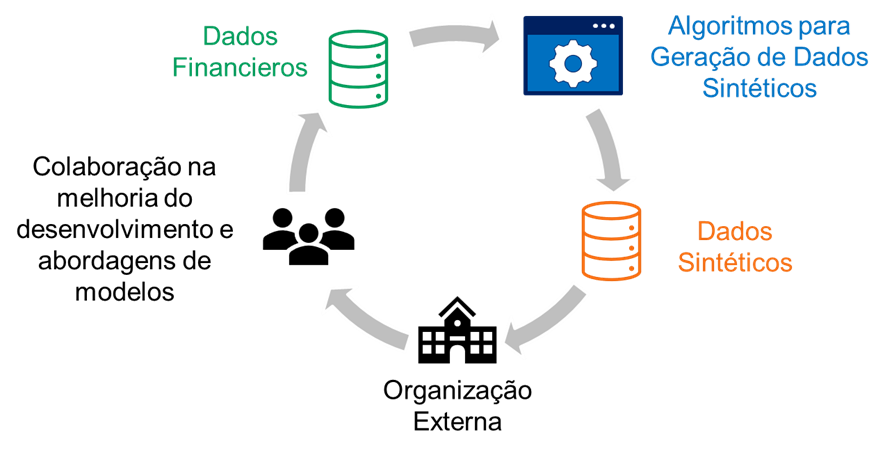

O objetivo é explorar abordagens e desenvolver algoritmos para produzir dados sintéticos financeiros, retendo o máximo de informações estatísticas para permitir o desenvolvimento de modelos de otimização de portfólios e outras aplicações financeiras.

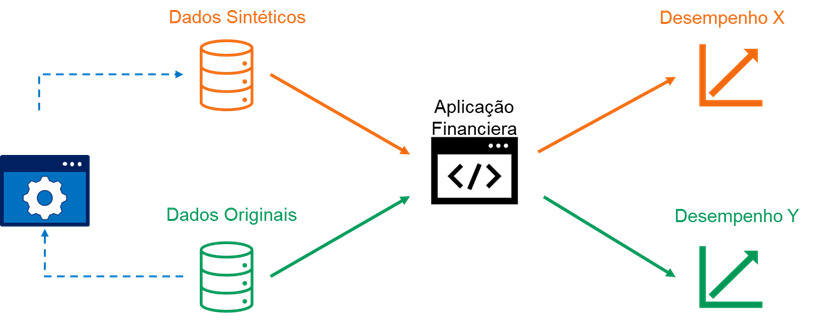

# Codigo do artigo de referencia

https://github.com/chuma9615/ctgan-portfolio-research

In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
id_config='1_-coVHZqz3NH_nNuYmqDR-uDJlXbwT5X'
downloaded = drive.CreateFile({'id':id_config})
downloaded.GetContentFile('config.zip')

In [ ]:
!unzip config.zip

Archive:  config.zip
  inflating: config.json             
   creating: src/
  inflating: src/backtester.py       
   creating: src/data/
  inflating: src/data/asset_prices.csv  
  inflating: src/data/features.csv   
   creating: src/generators/
  inflating: src/generators/gan_generator.py  
  inflating: src/generators/historical_generator.py  
  inflating: src/generators/normalizer.py  
  inflating: src/metrics.py          
  inflating: src/uryasev_optimization.py  
  inflating: src/utils.py            


In [ ]:
!pip install sdv==0.18.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 kB 2.2 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of rdt to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of rdt to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.1/64.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.8/63.8 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 4.2 MB/s eta 0:00:00
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce runtime. See https://pip.pypa.io/warnings/backtracking for guidance. If you want to abort this run, press Ctrl + C.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.5/59.5 kB 4.1 MB/s eta 

In [ ]:
!pip install hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 32.6 MB/s eta 0:00:00


In [ ]:
from sdv.tabular import CTGAN
print("CTGAN module is available.")

/usr/local/lib/python3.10/dist-packages/rdt/transformers/base.py:132: FutureWarning: Future versions of RDT will not support the 'model_missing_values' parameter. Please switch to using the 'missing_value_generation' parameter to select your strategy.
  warnings.warn(


CTGAN module is available.


In [ ]:
!pip show sdv

Name: sdv
Version: 0.18.0
Summary: Generate synthetic data for single table, multi table and sequential data
Home-page: https://github.com/sdv-dev/SDV
Author: DataCebo, Inc.
Author-email: info@sdv.dev
License: BSL-1.1
Location: /usr/local/lib/python3.10/dist-packages
Requires: cloudpickle, copulas, ctgan, deepecho, Faker, graphviz, numpy, pandas, rdt, sdmetrics, tqdm
Required-by: 


In [ ]:
# Standard library imports
import json
config = json.load(open("./config.json"))

In [ ]:
#config

{'generate_multiple_backstests': False,
 'model_names': ['historical'],
 'assets_path': './src/data/asset_prices.csv',
 'features_path': './src/data/features.csv',
 'plot_3d_points': False,
 'read_backtest': False,
 'read_samples': False,
 'use_features': True,
 'alpha': 0.95,
 'alpha_range': [0.8, 0.85, 0.9, 0.95],
 'bounds': [0.0, 1.0],
 'cvar': 0.01,
 'cvar_range': [0.01, 0.05, 0.1, 0.15, 0.2],
 'sample_size': 500,
 'lookback_years': 5,
 'returns_timeframe': 365}

In [ ]:
import pandas as pd
def load_data(config):
  asset_prices = pd.read_csv(config['assets_path'], index_col=0)
  asset_prices.index = pd.to_datetime(asset_prices.index)
  asset_returns = asset_prices.pct_change(config['returns_timeframe'])

  if config['use_features']:
      asset_returns = asset_returns.shift(-1*config['returns_timeframe'])
      features = pd.read_csv(config['features_path'], index_col=0)
      features.index = pd.to_datetime(features.index)
  else:
      features = None
  asset_returns = asset_returns.dropna()

  # dates where we rebalance in backtest
  rebalance_dates = asset_prices.resample('Y').last().index[config['lookback_years']+1:-1]
  return asset_prices, asset_returns, features, rebalance_dates

In [ ]:
asset_prices, asset_returns, features, rebalance_dates = load_data(config)

In [ ]:
asset_prices

,us_equities,us_equities_tech,global_equities,em_equities,us_hy,us_ig,em_debt,cmdty,long_term_treasuries,short_term_treasuries
date,,,,,,,,,,
2002-12-31,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2003-01-01,100.000000,100.000000,100.000000,100.037640,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2003-01-02,103.330233,104.419116,102.428842,100.686243,100.000000,99.106168,99.855467,102.573092,97.979289,99.717144
2003-01-03,103.280216,104.802111,102.752347,102.716393,99.925524,99.267621,100.090849,104.052273,98.041076,99.696192
2003-01-04,103.280216,104.802111,102.752347,102.716393,99.925524,99.267621,100.090849,104.052273,98.041076,99.696192
...,...,...,...,...,...,...,...,...,...,...
2022-06-10,651.749152,1411.521782,542.794738,609.864005,310.110195,236.072566,333.647175,154.747360,244.886198,140.516474
2022-06-11,651.749152,1411.521782,542.794738,609.864005,310.110195,236.072566,333.647175,154.747360,244.886198,140.516474
2022-06-12,651.749152,1411.521782,542.794738,609.864005,310.110195,236.072566,333.647175,154.747360,244.886198,140.516474


In [ ]:
asset_returns

,us_equities,us_equities_tech,global_equities,em_equities,us_hy,us_ig,em_debt,cmdty,long_term_treasuries,short_term_treasuries
date,,,,,,,,,,
2002-12-31,0.286652,0.494293,0.338222,0.558269,0.195806,0.072806,0.222126,0.239316,0.024833,0.019171
2003-01-01,0.286652,0.494293,0.338222,0.558964,0.195806,0.072806,0.222126,0.239316,0.024833,0.019171
2003-01-02,0.241424,0.426823,0.308806,0.575397,0.194850,0.075620,0.223109,0.208227,0.034641,0.020381
2003-01-03,0.242025,0.421609,0.304685,0.544260,0.195740,0.073870,0.220233,0.191051,0.033989,0.020596
2003-01-04,0.242025,0.421609,0.304685,0.544260,0.195740,0.073870,0.220233,0.191051,0.033989,0.020596
...,...,...,...,...,...,...,...,...,...,...
2021-06-10,-0.066640,-0.146223,-0.104127,-0.214525,-0.085683,-0.150113,-0.185064,0.429249,-0.182143,-0.039424
2021-06-11,-0.068474,-0.148538,-0.105694,-0.216398,-0.086303,-0.150082,-0.186975,0.429821,-0.180625,-0.039218
2021-06-12,-0.068474,-0.148538,-0.105694,-0.216398,-0.086303,-0.150082,-0.186975,0.429821,-0.180625,-0.039218


In [ ]:
features

,f_tenor_1,f_tenor_90,f_tenor_180,f_tenor_360,f_tenor_720,f_tenor_1800,f_tenor_3600,f_tenor_10800
date,,,,,,,,
2002-12-31,1.25,1.200,1.214,1.346,1.615,2.829,4.030,5.434
2003-01-01,1.25,1.200,1.224,1.349,1.600,2.827,4.035,5.434
2003-01-02,1.25,1.210,1.245,1.428,1.796,3.075,4.262,5.622
2003-01-03,1.25,1.221,1.256,1.427,1.772,3.075,4.246,5.626
2003-01-04,1.25,1.221,1.256,1.427,1.772,3.075,4.246,5.626
...,...,...,...,...,...,...,...,...
2022-06-10,1.00,1.353,1.943,2.551,3.041,3.227,3.126,3.104
2022-06-11,1.00,1.353,1.943,2.551,3.041,3.227,3.126,3.104
2022-06-12,1.00,1.353,1.943,2.551,3.041,3.227,3.126,3.104


In [ ]:
rebalance_dates

DatetimeIndex(['2008-12-31', '2009-12-31', '2010-12-31', '2011-12-31',
               '2012-12-31', '2013-12-31', '2014-12-31', '2015-12-31',
               '2016-12-31', '2017-12-31', '2018-12-31', '2019-12-31',
               '2020-12-31', '2021-12-31'],
              dtype='datetime64[ns]', name='date', freq='A-DEC')

In [ ]:
import numpy as np
def zscore_euclidean(spot_feature, sampled_features):
  mu = sampled_features.mean()
  sigma = sampled_features.std()
  spot_zscore = (spot_feature - mu)/sigma
  zscore = (sampled_features - mu)/sigma
  distance = np.sqrt(((zscore - spot_zscore)**2).sum(axis=1))
  return distance

In [ ]:
def save_file(matrix, path):
    np.savetxt(path, matrix, delimiter=",")

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

class Normalizer:
  def __init__(self, method='quantile'):
    self.method = method
    self.factor_columns = None
    self.total_columns = None
    self.params = {}

  def normalize(self, data):
    """ Normalization proces, returns a dataframe with each column normalized """
    self.total_columns = data.columns
    self.factor_columns = [x for x in data.columns if x.startswith('f_')]
    if self.method == 'quantile':
      self.params['quantile'] = preprocessing.QuantileTransformer(random_state=0)
      data[self.factor_columns] = self.params['quantile'].fit_transform(data[self.factor_columns])
    return data

  def denormalize(self, data):
    """ De-Normalization proces, given a normalized dataframe, returns an inverse-transformed dataframe """
    if self.method == 'quantile':
      if type(data) == pd.DataFrame:
        data[self.factor_columns] = self.params['quantile'].inverse_transform(data[self.factor_columns])

      elif type(data) == np.ndarray:
        data_df = pd.DataFrame(data, columns=self.total_columns)
        data_df[self.factor_columns] = self.params['quantile'].inverse_transform(data_df[self.factor_columns])
        data = data_df.values
    return data

In [ ]:
class HistoricalGenerator():
  """
  Generates a random sample, based on a historical dataset.
  """
  def __init__(self, asset_returns, features=None):
    self.features = features
    self.asset_returns = asset_returns
    self.name = 'historical'

  def generate_sample(self, sample_size, start_date, end_date, normalize_features=False):
    asset_returns_interval = self.asset_returns.loc[(self.asset_returns.index <= end_date)&(self.asset_returns.index >= start_date)]
    if self.features is not None:
      asset_returns_interval = asset_returns_interval.join(self.features, how='left').fillna(method='ffill')

    if normalize_features:
        normalizer = Normalizer()
        asset_returns_interval = normalizer.normalize(asset_returns_interval)
    else:
        normalizer = None

    total_windows = len(asset_returns_interval)
    size = sample_size if sample_size < total_windows else total_windows

    sample = np.random.choice(total_windows, size, replace=False)
    sample = asset_returns_interval.iloc[sample, :].reset_index(drop=True)

    if normalize_features:
        sample = normalizer.denormalize(sample)

    return sample.values

In [ ]:
# Standard library imports
import warnings

# Third party imports
import hdbscan
import pandas as pd
from sdv.tabular import CTGAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Local application imports
warnings.filterwarnings("ignore")

class CTGANGenerator():

    def __init__(self, asset_returns, params=None, features=None):
        self.asset_returns = asset_returns
        self.features = features
        self.name = 'CTGAN'
        self.params = params if params else {'embedding_dim': 128,
                           'generator_dim': (256, 256),
                           'discriminator_dim': (256, 256),
                           'epochs': 1500,
                           'generator_lr': 1e-4,
                           'discriminator_lr': 1e-4}


    def generate_sample(self, sample_size, start_date, end_date):

        model = CTGAN(**self.params)
        returns_interval = self.asset_returns.loc[
            (self.asset_returns.index <= end_date) & (self.asset_returns.index >= start_date)]
        fit_cols = list(self.asset_returns.columns) + ['cluster']
        normalizer = None

        if self.features is not None:
            returns_interval = returns_interval.join(self.features, how='left').fillna(method='ffill')
            normalizer = Normalizer()
            returns_interval = normalizer.normalize(returns_interval)
            fit_cols = list(self.asset_returns.columns) + list(self.features.columns) + ['cluster']


        # Applies PCA
        pca, returns_interval = self._construct_pca(returns_interval)
        fit_cols = [f"C_{i}" for i in range(pca.n_components_)] + ['cluster']


        # Dimensionality reduction
        returns_interval, X_embedded = self._reduce_dim(returns_interval)


        # Clusters definition
        returns_interval = self._define_clusters(returns_interval, X_embedded)

        # Fits CTGAN using categorical variable of state
        model.fit(returns_interval[fit_cols])

        sample = model.sample(sample_size)[fit_cols[:-1]]
        sample_val = sample.values

       # Reconstruct assets
        sample_val = pca.inverse_transform(sample_val)

        # De-normalizes
        if self.features is not None:
            sample_val = normalizer.denormalize(sample_val)


        return sample_val

    def _construct_pca(self, returns_interval):
        pca = PCA(n_components=returns_interval.shape[1])
        pca.fit(returns_interval)
        asset_returns_interval_trans = pca.transform(returns_interval)
        pca_cols = [f"C_{i}" for i in range(pca.n_components_)]
        return pca, pd.DataFrame(asset_returns_interval_trans,
                                        index=returns_interval.index,
                                        columns=pca_cols)

    def _reduce_dim(self, returns_interval, dims=2):
        X_embedded = TSNE(n_components=dims, learning_rate='auto', init='pca').fit_transform(returns_interval)
        returns_interval['x'] = X_embedded[:, 0]
        returns_interval['y'] = X_embedded[:, 1]
        return returns_interval, X_embedded

    def _define_clusters(self, returns_interval, X_embedded):
        cluster_dim = max(10, int(len(returns_interval) * 0.005))
        clusterer = hdbscan.HDBSCAN(min_samples=cluster_dim, min_cluster_size=cluster_dim)
        clusterer.fit(X_embedded)
        returns_interval['cluster'] = ['c_' + str(c) for c in clusterer.labels_]

        return returns_interval

In [ ]:
import numpy as np
from scipy.optimize import linprog
import pandas as pd



class UryasevOptimization():
    """
    Represents an Uryasev & Rockafeller optimization.
    """
    def __init__(self, alpha, cvar, bounds):
        self.alpha = alpha
        self.cvar = cvar
        self.bounds = bounds

    def get_optimal_portfolio(self, sample, density=None):
        '''
        Generates and resolves Uryasev's optimization problem.
        '''
        # define the probabilities for each window, all equal in this simple model
        if density is None:
                density = np.ones(len(sample))/len(sample)
        # our expected return will be the mean of the distribution
        mu = sample.T.dot(density)
        # start building the matrix for the linear optimization
        J = sample.shape[0]
        n = sample.shape[1]
        A = np.zeros((1 + J + J + 1 , 1 + n + J))
        b = np.zeros((1 + J + J + 1))
        i = 0
        c = np.zeros(1 + n + J)
        v = [(0, None) for x in range((1 + n + J))]

        # build bounds
        for i in range(n):
                v[1 + i] = self.bounds
        # build objetive function
        for i in range(n):
                c[1 + i] = - mu[i]
        # build restrictions
        for i in range(np.size(A, axis=0)):
                for k in range(np.size(A, axis=1)):
                        # cvar restriction
                        if i==0:
                                b[i] = self.cvar
                                if k==0:
                                        A[i, k] = 1
                                elif k in range(1 + n, 1 + n + J):
                                        A[i, k] = (1 - self.alpha)**-1*density[k -(1 + n)]
                        # select samples under threshold
                        elif i in range(1, 1+J):
                                b[i] = 0
                                if k == 0:
                                        A[i,k] = -1
                                elif k in range(1, 1 + n):
                                        A[i,k] = -sample[i - 1, k - 1]
                                elif k in range(1 + n, 1 + n + J) and (i - 1) == (k - (1 + n)):
                                        A[i,k] = -1
                        # z non-negativity
                        elif i in range(1 + J, 1 + J + J):
                                b[i] = 0
                                if k in range(1 + n, 1 + n + J) and (i-(1 + J + 1 + 2*n))==(k - (1 + n)):
                                        A[i,k] = -1
                        # 100% max investment (non-leveraged fund)
                        elif i in range(1 + J + J, 1 + J + J + 1):
                                b[i] = 1
                                if k in range(1, 1 + n):
                                        A[i,k] = 1
        # solve the problem
        optimal_result = linprog(c, A_ub=A, b_ub=b, bounds=v, options={"disp": False})
        optimal_portfolio = optimal_result.x[1:n+1]
        optimal_portfolio = pd.Series(optimal_portfolio)
        # remove scraps
        optimal_portfolio[optimal_portfolio<0.01] = 0
        optimal_portfolio /= optimal_portfolio.sum()
        optimal_portfolio *= 100
        return optimal_portfolio

#Metrics

In [ ]:
def compute_annualized_return(serie):
    '''
    Calculates the annualized return of a serie.
    '''
    annualized_return = (((serie.iloc[-1]/serie.iloc[0])**(365/(len(serie))))-1)*100
    return annualized_return

In [ ]:
def compute_cvar(serie, alpha=0.95, tf=365):
    '''
    Calculates the ex post CVAR of a serie.
    '''
    cvar = serie.pct_change(tf).dropna().sort_values()
    var = np.percentile(cvar, 100 - 100*alpha)
    cvar = cvar[cvar<=var]
    cvar = cvar.mean()
    cvar = -100 * cvar
    return cvar

In [ ]:
def compute_mean_hhi(portfolios):
    '''
    Calculates the diversification measure (HHI) for a set of historical portfolios.
    '''
    mean_hhi = pd.Series(dtype=float)
    for t, portfolio in portfolios.iterrows():
            m = len(portfolio)
            w = portfolio[portfolio>0.0]
            w /= 100
            hhi = w**2
            hhi = hhi.sum()
            hhi = (1-hhi) / (1-(1/m))
            mean_hhi[t] = hhi
    mean_hhi = mean_hhi.mean()
    return mean_hhi

In [ ]:
def compute_mean_rotation(portfolios):
    '''
    Calculates the mean absolute rotation of the historical portfolios
    '''
    rotation = portfolios.diff()
    rotation = rotation.dropna()
    rotation = rotation.abs()
    rotation = rotation.sum(axis=1)
    rotation /= 2
    mean_rotation = rotation.mean()
    return mean_rotation

In [ ]:
# 1. Initialize the Backtester
config = {
    "generate_multiple_backstests": False,
    "model_names": ["historical"],
    "assets_path": "/content/src/data/asset_prices.csv",
    "features_path": "/content/src/data/features.csv",
    "plot_3d_points": False,
    "read_backtest": False,
    "read_samples": False,
    "use_features": True,
    "alpha": 0.95,
    "alpha_range": [0.8, 0.85, 0.9, 0.95],
    "bounds": [0.0, 1.0],
    "cvar": 0.01,
    "cvar_range": [0.01, 0.05, 0.1, 0.15, 0.2],
    "sample_size": 500,
    "lookback_years": 5,
    "returns_timeframe": 365
}

In [ ]:
class Backtester():
  '''
  Entity responsible of backtests
  '''
  def __init__(self, asset_prices, asset_returns, config, rebalance_dates, features=None):
    self.asset_prices = asset_prices
    self.asset_returns = asset_returns
    self.config = config
    self.rebalance_dates = rebalance_dates
    self.features = features
    self.lookback_years = config['lookback_years']
    self.generators = self._instanciate_generators(config['model_names'])
    self.cvar = config['cvar']
    self.alpha = config['alpha']
    self.bounds = config['bounds']
    self.backtest_name = 'default'
  def _instanciate_generators(self, model_names):
    generators = []
    if 'historical' in model_names:
      historical_generator = HistoricalGenerator(asset_returns=self.asset_returns, features=self.features)
      generators.append(historical_generator)
    if 'CTGAN' in model_names:
      ctgan_generator = CTGANGenerator(asset_returns=self.asset_returns, features=self.features)
      generators.append(ctgan_generator)
    return generators
  def run_backtests(self, save=False):
    '''
    Runs a backtest and saves it in a json file. The name is for the case the caller runs several backtests.
    '''

    # first we generate the samples for each rebalance date
    samples = self.generate_samples()

    # we compute the optimizations for each rebalance date and store the portfolio of each model for each date
    in_sample_portfolios = self.build_in_sample_portfolios(samples, self.rebalance_dates,  self.lookback_years, self.cvar, self.alpha, self.bounds)

    # we run the performance of the historical portfolios
    backtests  = self.backtest_portfolios(historical_portfolios=in_sample_portfolios)

    # we add some interesting metrics for analysis
    backtests = self.compute_metrics(backtests=backtests)

    return backtests
  def generate_samples(self):
    '''
    Generates the samples for each rebalance date and for each model.
    '''
    print('generating samples:')
    # for each date and model we generate samples and store them in a dictionary
    samples = {}
    for rebalance_date in self.rebalance_dates:

        start_date, end_date = self._get_start_end_dates(rebalance_date)
        samples[rebalance_date] = {}
        print('    ' + str(rebalance_date.date()))

        for generator in self.generators:
            print(f"    {generator.name}: ")
            sample = generator.generate_sample(sample_size=self.config['sample_size'],
                                            start_date=start_date,
                                            end_date=end_date)
            samples[rebalance_date][generator.name] = sample

    return samples
  def _get_start_end_dates(self, rebalance_date):
    if self.features is None:
      end_date = rebalance_date
      start_date =  self.asset_returns[self.asset_returns.index<=end_date].resample('Y').last().index[-1*self.lookback_years-1]
    else:
      # this one is hard coded, won't work if we decide to change from 365 returns
      end_date = self.asset_returns[self.asset_returns.index<=rebalance_date].resample('Y').last().index[-2]
      start_date =  self.asset_returns[self.asset_returns.index<=end_date].resample('Y').last().index[-1*self.lookback_years-1]
    return start_date, end_date
  def build_in_sample_portfolios(self, samples, rebalance_dates, lookback_years, cvar, alpha, bounds):
    '''
    Given the samples, runs a uryasev optimisation for each rebalance date and model.
    '''

    print('running backtest optimizations:')
    # initialize optimitazion object
    uryasev_optimization = UryasevOptimization(alpha=alpha, cvar=cvar, bounds=bounds)
    portfolios = {}
    # for each date and model run an optimization problem
    for model in self.generators:
        print(f"    {model.name}: ")
        portfolios[model.name] = {}
        model_portfolios = pd.DataFrame(columns=self.asset_returns.columns)
        for rebalance_date in rebalance_dates:
            print(f"        {str(rebalance_date.date())}")
            sample = samples[rebalance_date][model.name]
            if self.features is not None:
                density = self.compute_density(sample, rebalance_date)
                sample_columns = self.asset_returns.columns.tolist() + self.features.columns.tolist()
            else:
                density = None
                sample_columns = self.asset_returns.columns.tolist()

            sample_assets = pd.DataFrame(sample, columns=sample_columns)[self.asset_returns.columns].values
            portfolio = uryasev_optimization.get_optimal_portfolio(sample=sample_assets, density=density)
            portfolio.index = self.asset_returns.columns
            model_portfolios.loc[rebalance_date] = portfolio
            portfolios[model.name] = model_portfolios

    return portfolios
  def compute_density(self, sample, rebalance_date):
    columns = self.asset_returns.columns.tolist() + self.features.columns.tolist()
    sampled_features = pd.DataFrame(sample, columns=columns)[self.features.columns]
    spot_feature = self.features.loc[rebalance_date]
    # use zscore normalized euclidean
    distances = 1 / zscore_euclidean(spot_feature, sampled_features)
    density = distances / distances.sum()
    return density.values
  def backtest_portfolios(self, historical_portfolios):
    '''
    Given a historical portfolio and the total returns, computes the performance backtest.
    '''
    print('running backtest performance')
    backtests = {}
    for model in self.generators:
        print(f"    {model.name}")
        backtests[model.name] = {}
        portfolios = historical_portfolios[model.name]
        backtest = portfolios.reindex(self.asset_prices.index)
        backtest = backtest.fillna(method='ffill').dropna()
        returns = self.asset_prices.pct_change()
        returns = returns.reindex(backtest.index)
        backtest *= returns
        backtest /= 100
        backtest = backtest.sum(axis=1)
        backtest.iloc[0] = 0
        backtest += 1
        backtest = backtest.cumprod()
        backtest *= 100
        backtests[model.name]['total_return_serie'] = backtest
        backtests[model.name]['portfolios'] = portfolios
    return backtests
  def compute_metrics(self, backtests):
    '''
    Calculates some ex post metrics.
    '''
    for model in self.generators:
        serie = backtests[model.name]['total_return_serie']
        portfolios = backtests[model.name]['portfolios']
        backtests[model.name]['annualized_return'] = compute_annualized_return(serie)
        backtests[model.name]['cvar_expost'] = compute_cvar(serie)
        backtests[model.name]['mean_hhi'] = compute_mean_hhi(portfolios)
        backtests[model.name]['mean_rotation'] = compute_mean_rotation(portfolios)

    return backtests
  def _instanciate_generators(self, model_names):
    generators = []
    if 'historical' in model_names:
      historical_generator = HistoricalGenerator(asset_returns=self.asset_returns, features=self.features)
      generators.append(historical_generator)
    if 'CTGAN' in model_names:
      ctgan_generator = CTGANGenerator(asset_returns=self.asset_returns, features=self.features)
      generators.append(ctgan_generator)
    return generators

In [ ]:
backtester = Backtester(
                        asset_prices=asset_prices,
                        asset_returns=asset_returns,
                        config=config,
                        rebalance_dates=rebalance_dates,
                        features=features)

In [ ]:
results = backtester.run_backtests(save=False)

generating samples:
    2008-12-31
    historical: 
    2009-12-31
    historical: 
    2010-12-31
    historical: 
    2011-12-31
    historical: 
    2012-12-31
    historical: 
    2013-12-31
    historical: 
    2014-12-31
    historical: 
    2015-12-31
    historical: 
    2016-12-31
    historical: 
    2017-12-31
    historical: 
    2018-12-31
    historical: 
    2019-12-31
    historical: 
    2020-12-31
    historical: 
    2021-12-31
    historical: 
running backtest optimizations:
    historical: 
        2008-12-31
        2009-12-31
        2010-12-31
        2011-12-31
        2012-12-31
        2013-12-31
        2014-12-31
        2015-12-31
        2016-12-31
        2017-12-31
        2018-12-31
        2019-12-31
        2020-12-31
        2021-12-31
running backtest performance
    historical


In [ ]:
synthetic_portfolios = results['historical']['portfolios']

In [ ]:
# 4. Inspect the generated synthetic portfolios to check for correctness
print(synthetic_portfolios.describe())

       us_equities  us_equities_tech  global_equities  em_equities  us_hy  \
count         14.0         14.000000             14.0    14.000000   14.0   
mean           0.0         47.199178              0.0     3.288790    0.0   
std            0.0         42.773125              0.0     5.829940    0.0   
min            0.0          0.000000              0.0     0.000000    0.0   
25%            0.0          0.000000              0.0     0.000000    0.0   
50%            0.0         55.053623              0.0     0.000000    0.0   
75%            0.0         92.231102              0.0     3.536972    0.0   
max            0.0        100.000000              0.0    14.844239    0.0   

           us_ig    em_debt  cmdty  long_term_treasuries  \
count  14.000000  14.000000   14.0             14.000000   
mean    0.128408   6.072967    0.0             33.516546   
std     0.480459  14.524596    0.0             29.523306   
min     0.000000   0.000000    0.0              0.000000   
25%   

In [ ]:
backtester = Backtester(
                        asset_prices=asset_prices,
                        asset_returns=asset_returns,
                        config=config,
                        rebalance_dates=rebalance_dates,
                        features=features)

In [ ]:
backtests = backtester.run_backtests()

generating samples:
    2008-12-31
    historical: 
    2009-12-31
    historical: 
    2010-12-31
    historical: 
    2011-12-31
    historical: 
    2012-12-31
    historical: 
    2013-12-31
    historical: 
    2014-12-31
    historical: 
    2015-12-31
    historical: 
    2016-12-31
    historical: 
    2017-12-31
    historical: 
    2018-12-31
    historical: 
    2019-12-31
    historical: 
    2020-12-31
    historical: 
    2021-12-31
    historical: 
running backtest optimizations:
    historical: 
        2008-12-31
        2009-12-31
        2010-12-31
        2011-12-31
        2012-12-31
        2013-12-31
        2014-12-31
        2015-12-31
        2016-12-31
        2017-12-31
        2018-12-31
        2019-12-31
        2020-12-31
        2021-12-31
running backtest performance
    historical


In [ ]:
# Print the keys of the results object
print(results.keys())

# Print the structure of the 'historical' model if it exists
if 'historical' in results:
    print(results['historical'].keys())

# Optionally, print a few rows of the portfolios if the key exists
if 'portfolios' in results['historical']:
    print(results['historical']['portfolios'].head())


dict_keys(['historical'])
dict_keys(['total_return_serie', 'portfolios', 'annualized_return', 'cvar_expost', 'mean_hhi', 'mean_rotation'])
            us_equities  us_equities_tech  global_equities  em_equities  \
2008-12-31          0.0               0.0              0.0    13.170367   
2009-12-31          0.0               0.0              0.0    14.844239   
2010-12-31          0.0               0.0              0.0     4.715963   
2011-12-31          0.0               0.0              0.0    13.312486   
2012-12-31          0.0               0.0              0.0     0.000000   

            us_hy  us_ig    em_debt  cmdty  long_term_treasuries  \
2008-12-31    0.0    0.0   0.000000    0.0             50.249618   
2009-12-31    0.0    0.0   0.000000    0.0             85.155761   
2010-12-31    0.0    0.0  31.493191    0.0             63.790845   
2011-12-31    0.0    0.0   6.338689    0.0             80.348824   
2012-12-31    0.0    0.0  47.189655    0.0             52.810345   

 

In [ ]:
# Extract the synthetic portfolios for a model (e.g., 'CTGAN')
synthetic_portfolios = results['historical']['portfolios']

In [ ]:
def prepare_data_for_pairplot(asset_returns, synthetic_data):
    """
    Prepares the data from original asset returns and synthetic data to be used for pair-plot comparison.
    Combines original (asset_returns) and synthetic data into a single DataFrame and applies log scaling.
    """
    # Apply log scaling to both original and synthetic data to handle large ranges
    asset_returns_log = asset_returns.apply(lambda x: np.log1p(x))  # log1p(x) = log(1 + x)
    synthetic_data_log = synthetic_data.apply(lambda x: np.log1p(x))

    # Original asset returns
    weighted_original_returns = asset_returns_log.copy()
    weighted_original_returns['Dataset'] = 'Original'

    # Synthetic data (portfolios)
    weighted_synthetic_returns = synthetic_data_log.copy()
    weighted_synthetic_returns['Dataset'] = 'Synthetic'

    # Combine both datasets for comparison
    combined_df = pd.concat([weighted_original_returns, weighted_synthetic_returns])

    return combined_df

In [ ]:
def plot_pair_comparison(asset_returns, synthetic_data, title="Pair-plot comparison of original vs synthetic data"):
    """
    Generates a pair-plot to compare asset returns (original) vs synthetic data by asset class.
    """
    # Prepare the data for pairplot
    combined_data = prepare_data_for_pairplot(asset_returns, synthetic_data)

    # Generate the pairplot for the asset returns, distinguishing by the dataset (Original vs Synthetic)
    sns.pairplot(combined_data, hue='Dataset', plot_kws={'alpha': 0.5, 's': 25}, corner=True)

    # Add title
    plt.suptitle(title, y=1.02, fontsize= 16)
    plt.tight_layout()
    plt.show()

In [ ]:
print(asset_returns.describe())

       us_equities  us_equities_tech  global_equities  em_equities  \
count  6741.000000       6741.000000      6741.000000  6741.000000   
mean      0.120687          0.171010         0.112153     0.134472   
std       0.157434          0.188492         0.169592     0.268783   
min      -0.474976         -0.480819        -0.499748    -0.644166   
25%       0.060377          0.058015         0.026674    -0.040504   
50%       0.136869          0.170782         0.134091     0.148505   
75%       0.198218          0.285477         0.197803     0.274142   
max       0.777753          0.888779         0.776371     1.145958   

             us_hy        us_ig      em_debt        cmdty  \
count  6741.000000  6741.000000  6741.000000  6741.000000   
mean      0.067011     0.054393     0.073238     0.026568   
std       0.103799     0.064746     0.088939     0.198672   
min      -0.310331    -0.170856    -0.272818    -0.521446   
25%       0.021980     0.009702     0.024626    -0.087469   
50%

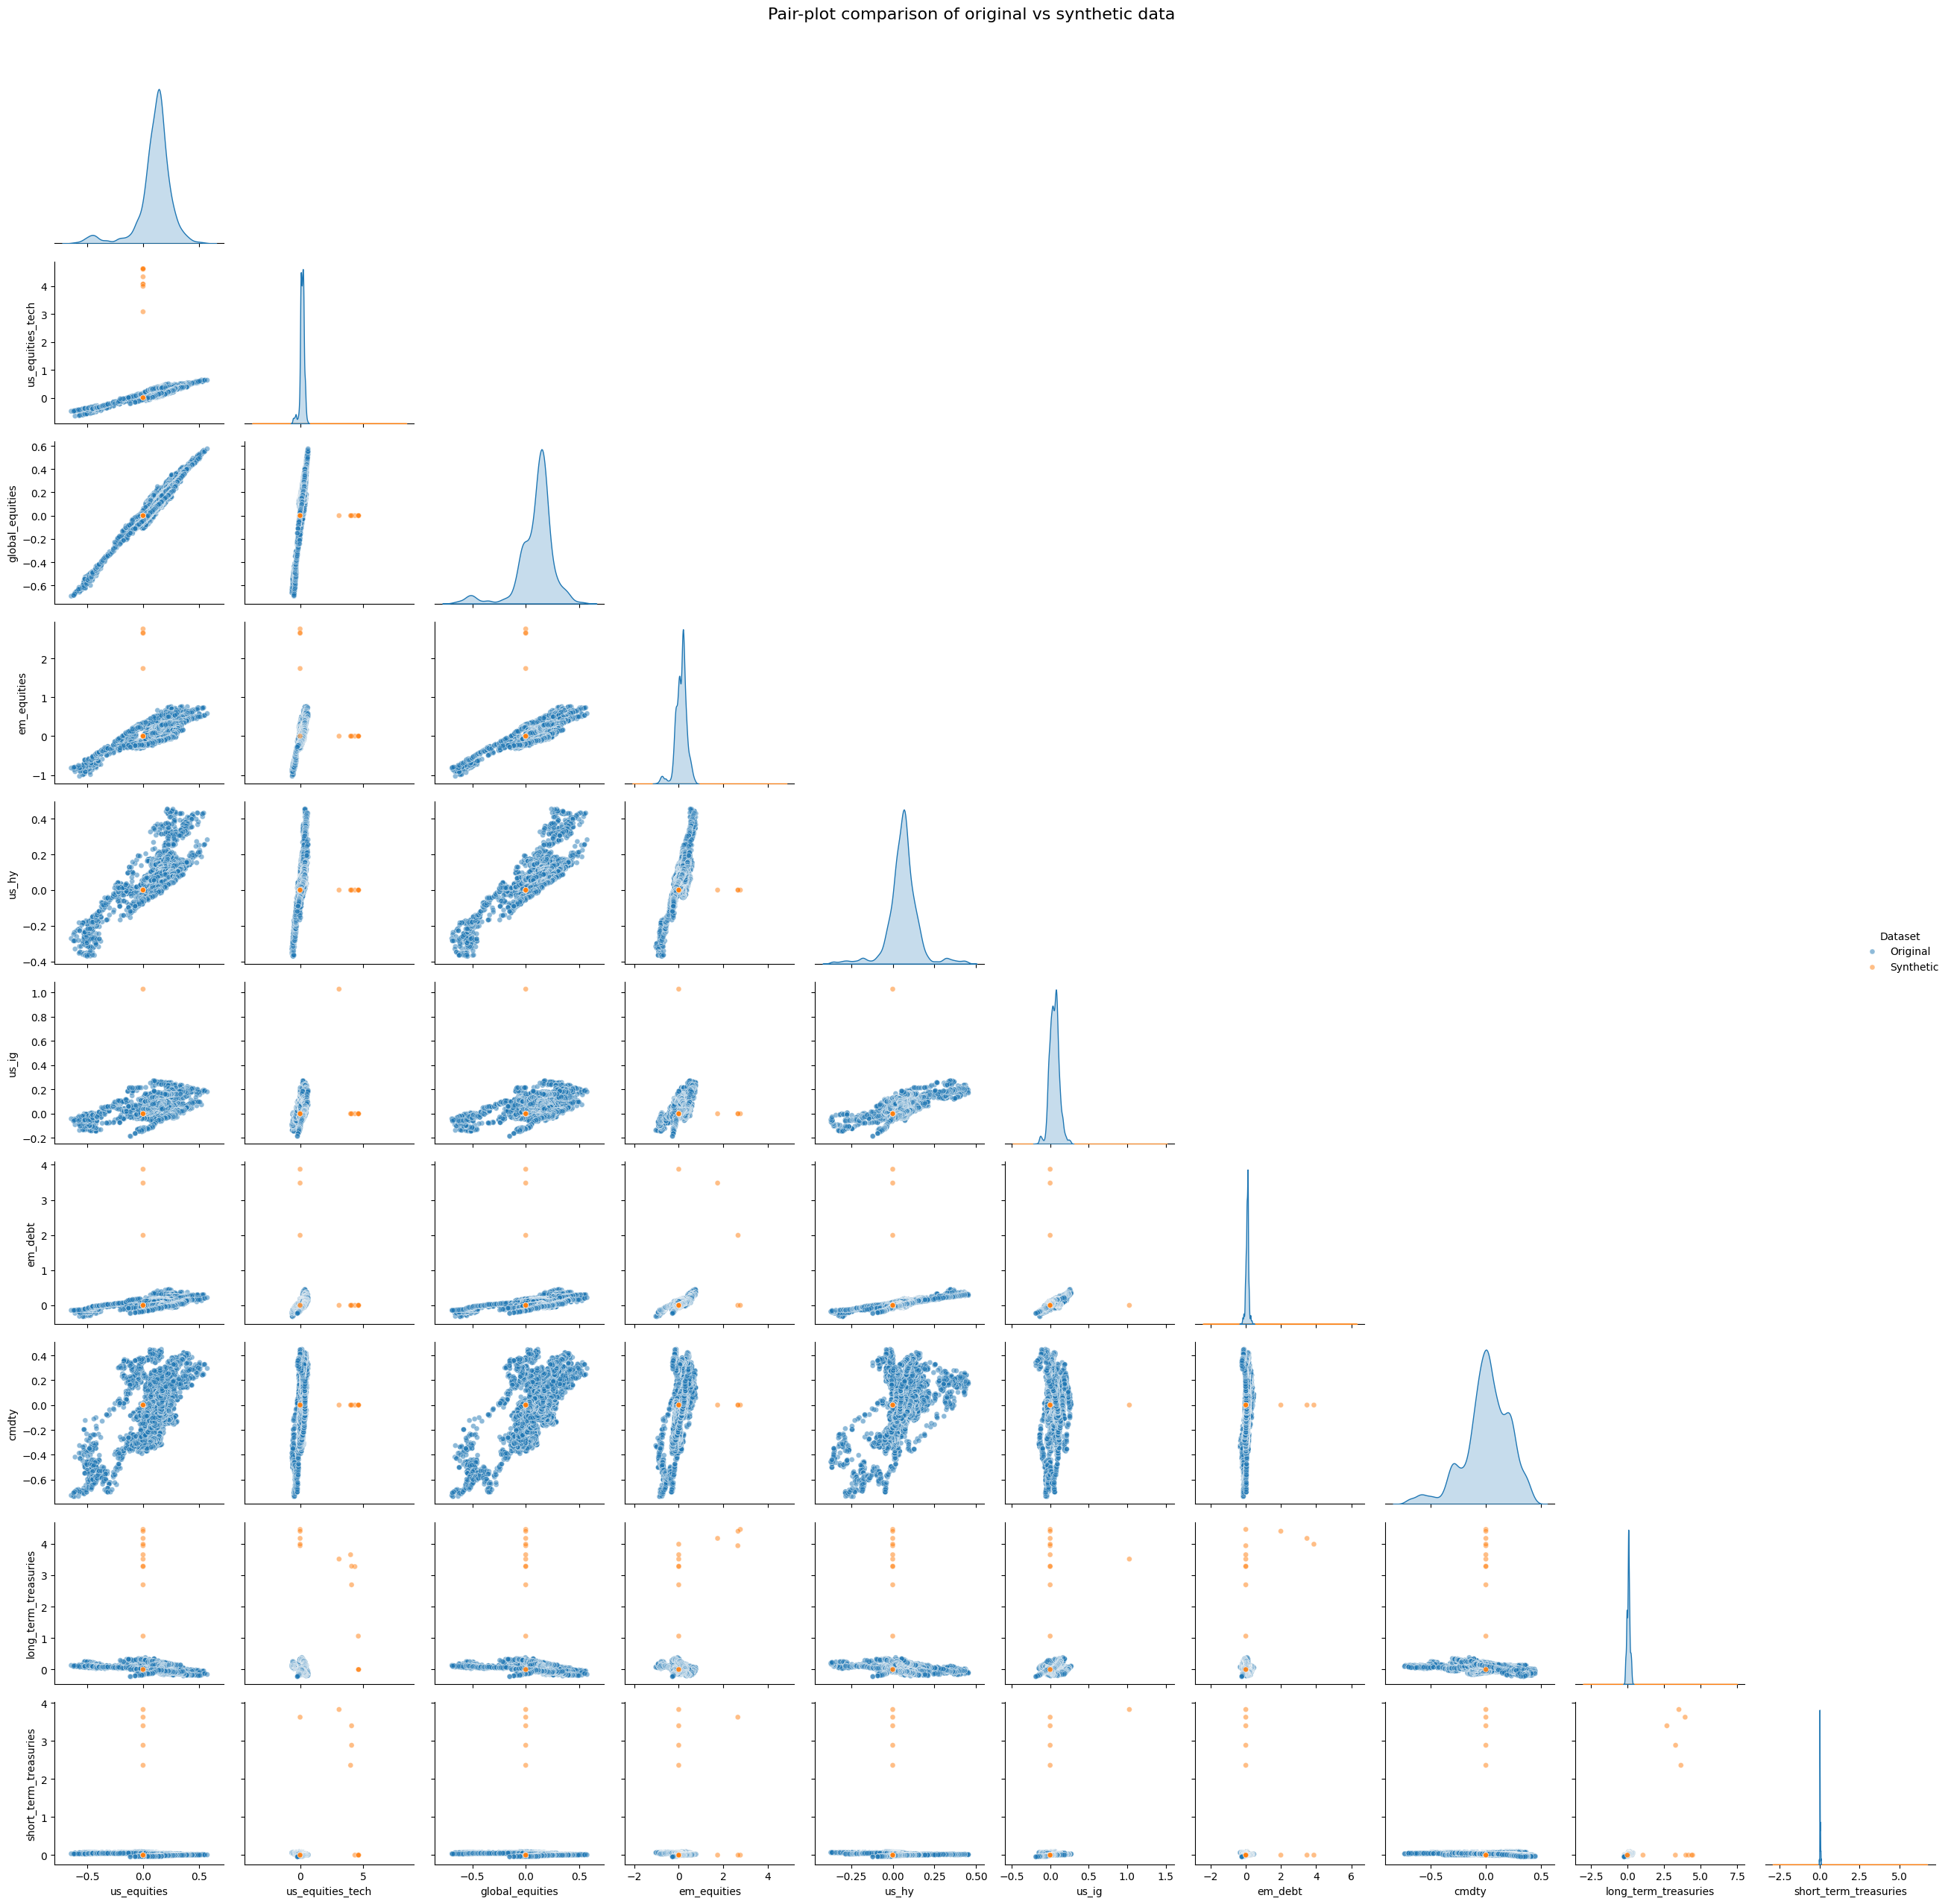

In [ ]:
plot_pair_comparison(asset_returns, synthetic_portfolios)

In [ ]:
def save_backtest_results(results, output_dir):
    """
    Save the backtest results (portfolios and total return series) to CSV files.

    Parameters:
    - results: Dictionary containing backtest results.
    - output_dir: Directory where the CSV files will be saved.
    """
    for model_name, model_data in results.items():
        # Save total return series to CSV
        total_return_file = f"{output_dir}/{model_name}_total_return.csv"
        model_data['total_return_serie'].to_csv(total_return_file)
        print(f"Saved total return series for {model_name} to {total_return_file}")

        # Save portfolio allocations to CSV
        portfolio_file = f"{output_dir}/{model_name}_portfolios.csv"
        model_data['portfolios'].to_csv(portfolio_file)
        print(f"Saved portfolio allocations for {model_name} to {portfolio_file}")

In [ ]:
save_backtest_results(backtests, '/content/')

Saved total return series for historical to /content//historical_total_return.csv
Saved portfolio allocations for historical to /content//historical_portfolios.csv


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_total_return(results):
    """
    Plots the cumulative total return over time for each model in the backtest.
    """
    plt.figure(figsize=(10, 6))
    for model_name, data in results.items():
        total_return = data['total_return_serie']
        plt.plot(total_return.index, total_return.values, label=model_name)

    plt.title('Cumulative Total Return Over Time')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True)
    plt.show()

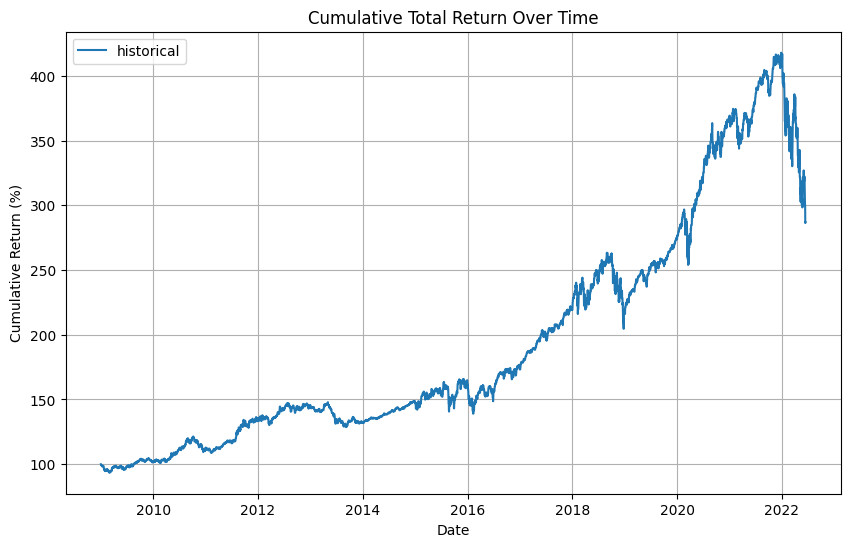

In [ ]:
plot_total_return(results)

In [ ]:
backtests

{'historical': {'total_return_serie': date
  2008-12-31    100.000000
  2009-01-01    100.034864
  2009-01-02     99.366324
  2009-01-03     99.366324
  2009-01-04     99.366324
                   ...    
  2022-06-10    302.975501
  2022-06-11    302.975501
  2022-06-12    302.975501
  2022-06-13    289.033755
  2022-06-14    289.678124
  Length: 4914, dtype: float64,
  'portfolios':             us_equities  us_equities_tech  global_equities  em_equities  \
  2008-12-31          0.0          0.000000              0.0    16.897163   
  2009-12-31          0.0          0.000000              0.0    13.429542   
  2010-12-31          0.0          0.000000              0.0     5.515837   
  2011-12-31          0.0          0.000000              0.0    15.595205   
  2012-12-31          0.0          0.000000              0.0     0.000000   
  2013-12-31          0.0         21.626988              0.0     0.000000   
  2014-12-31          0.0        100.000000              0.0     0.000000  